## Imports

In [57]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [58]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Leitura Dados

In [59]:
X = pd.read_csv('./2d/sr3/X_train.csv').drop(columns=['index', 'Unnamed: 0'])
y = pd.read_csv('./2d/sr3/y_train.csv').drop(columns=['index', 'Unnamed: 0'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_test = pd.read_csv('./2d_test/sr3/X_test.csv').drop(columns=['index', 'Unnamed: 0'])
y_test = pd.read_csv('./2d_test/sr3/y_test.csv').drop(columns=['index', 'Unnamed: 0'])


In [60]:
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')

print('')
print(f'Input shape: {X_train.shape}')
print(f'Output shape: {y_train.shape}')

Train: 9665
Validation: 3222
Test: 1315

Input shape: (9665, 225)
Output shape: (9665, 175)


In [61]:
def df2tensor(df, ni, nj):
    t1 = torch.tensor(df.values)
    t2 = torch.reshape(t1, (len(df), -1, ni, nj))
    return t2.float()

In [62]:
X_train_t = df2tensor(X_train, 5, 5)
y_train_t = df2tensor(y_train, 5, 5)

X_val_t = df2tensor(X_val, 5, 5)
y_val_t = df2tensor(y_val, 5, 5)

X_test_t = df2tensor(X_test, 5, 5)
y_test_t = df2tensor(y_test, 5, 5)

In [63]:
sample = int(np.random.random()*len(X_train_t))
print(f'Sample {sample}')
for i,c in enumerate([c[:-2] for c in X_train.columns if c[-2:]=='_0']):
    print(c)
    print(X_train_t[sample][i])

Sample 148
Por
tensor([[0.0970, 0.1460, 0.1400, 0.1090, 0.1020],
        [0.0950, 0.1250, 0.1550, 0.1170, 0.1070],
        [0.1080, 0.1100, 0.1400, 0.1490, 0.1350],
        [0.1340, 0.1010, 0.1340, 0.1640, 0.1450],
        [0.1440, 0.1410, 0.1510, 0.1900, 0.1630]])
PermI
tensor([[ 14.3000,  72.6000,  50.2000,  27.4000,  22.9000],
        [  8.6000,  68.2000, 165.7000,  20.6000,  23.2000],
        [ 16.5000,  36.2000,  97.1000, 106.5000,  34.5000],
        [ 35.2000,   8.8000,  50.5000,  95.7000,  40.1000],
        [ 98.8000,  57.2000,  68.0000, 111.3000,  88.2000]])
PermJ
tensor([[ 18.9000,  87.7000,  53.6000,  28.4000,  23.3000],
        [  9.8000, 126.5000, 166.9000,  28.2000,  27.7000],
        [ 17.7000,  47.6000,  95.7000, 114.6000,  43.8000],
        [ 28.7000,   8.8000,  59.1000,  98.2000,  58.2000],
        [ 94.7000,  42.9000,  65.0000, 254.1000, 118.1000]])
Pres
tensor([[329.8940, 398.6395, 410.9751, 418.2667, 423.1797],
        [383.1369, 408.1236, 416.9061, 425.1298, 430.32

In [95]:
print(f'Sample {sample}')
for i,c in enumerate([c[:-2] for c in y_train.columns if c[-2:]=='_0']):
    print(c)
    print(y_train_t[sample][i])

Sample 148
Pres
tensor([[329.9799, 398.7669, 411.1087, 418.4025, 423.3161],
        [383.2655, 408.2551, 417.0388, 425.2619, 430.4532],
        [409.3026, 415.8029, 425.2429, 433.1163, 438.4783],
        [420.2631, 425.4467, 434.1626, 440.7350, 447.8081],
        [427.0837, 432.1332, 438.8015, 445.8009, 456.5418]])
Sw
tensor([[0.2421, 0.2645, 0.2596, 0.2301, 0.2282],
        [0.2328, 0.2989, 0.3195, 0.3117, 0.3071],
        [0.2049, 0.3013, 0.3417, 0.3565, 0.3582],
        [0.1986, 0.2689, 0.3496, 0.3800, 0.3997],
        [0.2467, 0.3163, 0.3652, 0.4050, 0.4471]])
Kro
tensor([[0.1320, 0.1021, 0.1079, 0.1511, 0.1542],
        [0.1466, 0.0661, 0.0498, 0.0559, 0.0595],
        [0.1963, 0.0640, 0.0359, 0.0284, 0.0276],
        [0.2088, 0.0971, 0.0319, 0.0188, 0.0129],
        [0.1256, 0.0523, 0.0246, 0.0117, 0.0045]])
Krw
tensor([[0.0142, 0.0232, 0.0210, 0.0102, 0.0096],
        [0.0110, 0.0399, 0.0515, 0.0470, 0.0444],
        [0.0035, 0.0412, 0.0652, 0.0750, 0.0761],
        [0.0020, 0.0

In [64]:
# AA = X_train_t.view(X_train_t.size(0), -1)
# AA -= AA.min(1, keepdim=True)[0]
# AA /= AA.max(1, keepdim=True)[0]
# AA = AA.view(batch_size, height, width)

In [65]:
# AA = X_train_t.view(X_train_t.size(0), X_train_t.size(1), -1)
# min_values, _ = AA.min(dim=2, keepdim=True)

In [66]:
# AA = torch.transpose(X_train_t, 0, 1)
# AA = AA.reshape(AA.size(0), -1)

# min_values, _ = AA.min(dim=1, keepdim=False)
# print(f'Min.values: {min_values}')

# max_values, _ = AA.max(dim=1, keepdim=False)
# print(f'Max.values: {max_values}')

In [67]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (
            self.X[idx],
            self.y[idx]
        )
        return sample

In [68]:
data_train = CustomDataset(X_train_t, y_train_t)
data_val = CustomDataset(X_val_t, y_val_t)
data_test = CustomDataset(X_test_t, y_test_t)

In [69]:
batch_size = 16
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [70]:
for X,y in dataloader_val:
    print(f'Input shape: {X.shape}')
    print(f'Output shape: {y.shape}')
    break

Input shape: torch.Size([16, 9, 5, 5])
Output shape: torch.Size([16, 7, 5, 5])


## Neural Network

In [71]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, latent_size, max_size, recurrences):
        super(Network,self).__init__()
        self.enc_1 = nn.Conv2d(  input_size, 2*input_size, 1, padding=0)
        self.enc_2 = nn.Conv2d(2*input_size,  latent_size, 1, padding=0)
        self.enc_3 = nn.Conv2d( latent_size,  latent_size, 1, padding=0)
        self.enc_4 = nn.Conv2d( latent_size,  latent_size, 1, padding=0)

        self.proc_1 = nn.Conv2d(  latent_size, 2*latent_size, 3, padding=1)
        self.proc_2 = nn.Conv2d(2*latent_size,      max_size, 3, padding=1)
        self.proc_3 = nn.Conv2d(     max_size,      max_size, 3, padding=1)
        self.proc_4 = nn.Conv2d(     max_size,      max_size, 3, padding=1)
        self.proc_5 = nn.Conv2d(     max_size, 2*latent_size, 3, padding=1)
        self.proc_6 = nn.Conv2d(2*latent_size,   latent_size, 3, padding=1)

        self.dec_1 = nn.Conv2d(  latent_size,   latent_size, 1, padding=0)
        self.dec_2 = nn.Conv2d(  latent_size, 2*output_size, 1, padding=0)
        self.dec_3 = nn.Conv2d(2*output_size,   output_size, 1, padding=0)
        self.dec_4 = nn.Conv2d(  output_size,   output_size, 1, padding=0)
        self.dec_5 = nn.Conv2d(  output_size,   output_size, 1, padding=0)

        self.recurrences = recurrences

    def forward(self, x):
        x = self.enc_1(x)
        x = F.relu(x)
        x = self.enc_2(x)
        x = F.relu(x)
        x = self.enc_3(x)
        x = F.relu(x)
        x = self.enc_4(x)
        x = F.relu(x)

        for _ in range(self.recurrences):
            residual = x
            x = self.proc_1(x)
            x = F.relu(x)
            x = self.proc_2(x)
            x = F.relu(x)
            x = self.proc_3(x)
            x = F.relu(x)
            x = self.proc_4(x)
            x = F.relu(x)
            x = self.proc_5(x)
            x = F.relu(x)
            x = self.proc_6(x)
            x += residual
            x = F.relu(x)

        x = self.dec_1(x)
        x = F.relu(x)
        x = self.dec_2(x)
        x = F.relu(x)
        x = self.dec_3(x)
        x = F.relu(x)
        x = self.dec_4(x)
        x = F.relu(x)
        x = self.dec_5(x)
        return x

In [72]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=32,
    max_size=64,
    recurrences=2)

some_data = X_train_t
print(f'Input: {some_data.shape}')
loss_fn = nn.MSELoss()
result = model(some_data)
print(f'Result: {result.shape}')

loss = loss_fn(result, y_train_t)
loss.backward()
print(f'Loss = {loss:0.2f}')

Input: torch.Size([9665, 9, 5, 5])
Result: torch.Size([9665, 7, 5, 5])
Loss = 32241.03


In [73]:
torch.onnx.export(model, X_test_t, 'test.onnx', input_names=["features"], output_names=["results"])
# https://machinelearningmastery.com/visualizing-a-pytorch-model/
# https://netron.app/

In [74]:
total = 0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Parameters: {param.numel()}")
    total += param.numel()
print(f'Total: {total}')

Layer: enc_1.weight | Parameters: 162
Layer: enc_1.bias | Parameters: 18
Layer: enc_2.weight | Parameters: 576
Layer: enc_2.bias | Parameters: 32
Layer: enc_3.weight | Parameters: 1024
Layer: enc_3.bias | Parameters: 32
Layer: enc_4.weight | Parameters: 1024
Layer: enc_4.bias | Parameters: 32
Layer: proc_1.weight | Parameters: 18432
Layer: proc_1.bias | Parameters: 64
Layer: proc_2.weight | Parameters: 36864
Layer: proc_2.bias | Parameters: 64
Layer: proc_3.weight | Parameters: 36864
Layer: proc_3.bias | Parameters: 64
Layer: proc_4.weight | Parameters: 36864
Layer: proc_4.bias | Parameters: 64
Layer: proc_5.weight | Parameters: 36864
Layer: proc_5.bias | Parameters: 64
Layer: proc_6.weight | Parameters: 18432
Layer: proc_6.bias | Parameters: 32
Layer: dec_1.weight | Parameters: 1024
Layer: dec_1.bias | Parameters: 32
Layer: dec_2.weight | Parameters: 448
Layer: dec_2.bias | Parameters: 14
Layer: dec_3.weight | Parameters: 98
Layer: dec_3.bias | Parameters: 7
Layer: dec_4.weight | Para

## Ajuste

In [75]:
def plot_losses(train_losses, val_losses):
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train')
    plt.plot(range(1,len(train_losses)+1), val_losses, label='Val')
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Model Training")
    plt.legend()
    plt.grid(True)
    plt.show()

In [76]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss)

        loss.backward()
        optimizer.step()

        if verbose:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return float(torch.tensor(losses).mean())

def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

def train(model: Network,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          epochs: int,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          file_name='model.pth',
          verbose=False):

    best_val = np.inf
    train_loss = []
    val_loss = []
    print("=> Starting training")
    for t in range(epochs):
        if verbose:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loss.append(train_loop(train_dataloader, model, loss_fn, optimizer, verbose))
        val_loss.append(  test_loop(val_dataloader, model, loss_fn))
        star = ''
        if val_loss[-1] < best_val:
            best_val = val_loss[-1]
            torch.save(model, file_name)
            star = '*'
        print(f' {t + 1}: train = {train_loss[-1]:0.4g}, val = {val_loss[-1]:0.4g}{star}')
    print("Done!")
    best_model = torch.load(file_name)
    return best_model, (train_loss, val_loss)

=> Starting training
 1: train = 2.627e+04, val = 1.958e+04*
 2: train = 1.846e+04, val = 1.776e+04*
 3: train = 1.688e+04, val = 1.612e+04*
 4: train = 1.514e+04, val = 1.435e+04*
 5: train = 1.356e+04, val = 1.298e+04*
 6: train = 1.232e+04, val = 1.177e+04*
 7: train = 1.123e+04, val = 1.058e+04*
 8: train = 1.021e+04, val = 1.022e+04*
 9: train = 9363, val = 8780*
 10: train = 8461, val = 7984*
 11: train = 7758, val = 7138*
 12: train = 7123, val = 6638*
 13: train = 6553, val = 6504*
 14: train = 6028, val = 5988*
 15: train = 5594, val = 5016*
 16: train = 5080, val = 5232
 17: train = 4707, val = 4187*
 18: train = 4412, val = 4288
 19: train = 4156, val = 4258
 20: train = 3847, val = 3681*
 21: train = 3627, val = 3571*
 22: train = 3540, val = 3565*
 23: train = 3343, val = 3222*
 24: train = 3356, val = 3314
 25: train = 3238, val = 3078*
 26: train = 3210, val = 3144
 27: train = 3179, val = 3459
 28: train = 3191, val = 2959*
 29: train = 3088, val = 3373
 30: train = 306

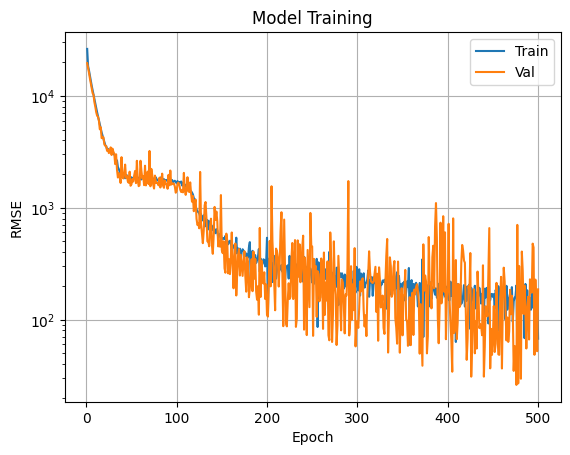

Test loss = 2906 (last model)
Test loss = 2813 (best model)


In [77]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=32,
    max_size=64,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)  # ok
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001)  # ok

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

In [96]:
print(f'Sample {sample}')
for i,c in enumerate([c[:-2] for c in y_train.columns if c[-2:]=='_0']):
    print(c)
    print(y_train_t[sample][i])

Sample 148
Pres
tensor([[329.9799, 398.7669, 411.1087, 418.4025, 423.3161],
        [383.2655, 408.2551, 417.0388, 425.2619, 430.4532],
        [409.3026, 415.8029, 425.2429, 433.1163, 438.4783],
        [420.2631, 425.4467, 434.1626, 440.7350, 447.8081],
        [427.0837, 432.1332, 438.8015, 445.8009, 456.5418]])
Sw
tensor([[0.2421, 0.2645, 0.2596, 0.2301, 0.2282],
        [0.2328, 0.2989, 0.3195, 0.3117, 0.3071],
        [0.2049, 0.3013, 0.3417, 0.3565, 0.3582],
        [0.1986, 0.2689, 0.3496, 0.3800, 0.3997],
        [0.2467, 0.3163, 0.3652, 0.4050, 0.4471]])
Kro
tensor([[0.1320, 0.1021, 0.1079, 0.1511, 0.1542],
        [0.1466, 0.0661, 0.0498, 0.0559, 0.0595],
        [0.1963, 0.0640, 0.0359, 0.0284, 0.0276],
        [0.2088, 0.0971, 0.0319, 0.0188, 0.0129],
        [0.1256, 0.0523, 0.0246, 0.0117, 0.0045]])
Krw
tensor([[0.0142, 0.0232, 0.0210, 0.0102, 0.0096],
        [0.0110, 0.0399, 0.0515, 0.0470, 0.0444],
        [0.0035, 0.0412, 0.0652, 0.0750, 0.0761],
        [0.0020, 0.0

In [97]:
print(f'Sample {sample}')
pred_sample = best_model(X_train_t[sample])
for i,c in enumerate([c[:-2] for c in y_train.columns if c[-2:]=='_0']):
    print(c)
    print(pred_sample[i])

Sample 148
Pres
tensor([[330.7854, 385.9558, 407.4757, 418.9194, 424.6663],
        [382.9357, 399.3064, 414.4547, 420.1373, 425.8438],
        [401.4436, 411.8992, 419.0153, 424.3041, 430.8936],
        [415.1205, 420.2472, 426.8886, 431.5408, 439.2998],
        [419.6556, 423.9777, 429.6349, 441.4640, 447.5763]],
       grad_fn=<SelectBackward0>)
Sw
tensor([[-1.2474,  0.4241, -0.0564,  0.2523,  0.4134],
        [ 0.1738,  0.6605,  0.3775,  0.2347,  0.4071],
        [ 0.0996,  0.2734,  0.3169,  0.2082,  0.3387],
        [ 0.1870,  0.3153,  0.3650,  0.1448,  0.4283],
        [ 0.1272,  0.3832,  0.3907,  0.2506,  1.7315]],
       grad_fn=<SelectBackward0>)
Kro
tensor([[ 6.6746e-01, -1.7168e-01,  5.8473e-01,  1.2223e-01, -9.8706e-03],
        [ 2.0920e-01, -5.2160e-01, -7.3858e-02,  1.5029e-01, -1.0865e-01],
        [ 3.4004e-01,  8.3402e-02,  2.3294e-02,  1.9479e-01,  8.5625e-04],
        [ 2.1876e-01,  2.6839e-02, -4.3085e-02,  2.9867e-01, -1.2874e-01],
        [ 3.1457e-01, -7.3858e-0

## Teste Recorrência

In [98]:
import sys
sys.path.insert(0, '../python')
from simpython.cmg import sr3reader
import read_sr3

In [99]:
sim_days = 365*5
sim_number = 19

file_name = f'./2d_test/sr3/sens_{sim_number}.sr3'

In [100]:
sr3 = sr3reader.Sr3Reader(file_name)
sr3_data = read_sr3.read_data(sr3, days=[1])

Pwf_prod = sr3.get_data(
    element_type='well',
    property_names='BHP',
    element_names='P01',
    days=range(1, sim_days))

Np_prod = sr3.get_data(
    element_type='well',
    property_names='NP',
    element_names='P01',
    days=range(1, sim_days))

Qo_prod = sr3.get_data(
    element_type='well',
    property_names='QO',
    element_names='P01',
    days=range(1, sim_days))

Wp_prod = sr3.get_data(
    element_type='well',
    property_names='WP',
    element_names='P01',
    days=range(1, sim_days))

Qw_prod = sr3.get_data(
    element_type='well',
    property_names='QW',
    element_names='P01',
    days=range(1, sim_days))

Pwf_inj = sr3.get_data(
    element_type='well',
    property_names='BHP',
    element_names='I01',
    days=range(1, sim_days))

Wp_inj = sr3.get_data(
    element_type='well',
    property_names='WP',
    element_names='I01',
    days=range(1, sim_days))

Qw_inj = sr3.get_data(
    element_type='well',
    property_names='QW',
    element_names='I01',
    days=range(1, sim_days))

In [101]:
wells = {'P01':0, 'I01':24}
sim_data = read_sr3.organize_data(sr3_data[0], wells)

t1 = torch.tensor(sim_data['in'])
t2 = torch.reshape(t1, (-1, 5, 5))
sim_data_t = t2.float()
sim_data_t = sim_data_t

In [102]:
[c[:-2] for c in X_train.columns if c[-2:]=='_0']

['Por', 'PermI', 'PermJ', 'Pres', 'Sw', 'Kro', 'Krw', 'Pwf', 'QwI']

In [103]:
[c[:-2] for c in y_train.columns if c[-2:]=='_0']

['Pres', 'Sw', 'Kro', 'Krw', 'Qo', 'Qw', 'PwfI']

In [104]:
def value2map(value, position):
    array_ = np.zeros(25)
    array_[position] = value
    t1_ = torch.tensor(array_)
    t2_ = torch.reshape(t1_, (-1, 5, 5))
    return t2_.float()

In [105]:
Qo_nn = []
Qw_nn = []
Pwf_inj_nn = []
current_state = sim_data_t.clone()

for i in range(1,sim_days-1):

    pred = best_model(current_state)

    Qo_nn.append(float(pred[4][0][0]))
    Qw_nn.append(float(pred[5][0][0]))
    Pwf_inj_nn.append(float(pred[6][4][4]))

    stat_data = sim_data_t[0:3]
    new_state = pred[0:4]
    control_Pwf = value2map((Pwf_prod[i,1]+Pwf_prod[i-1,1])/2, 0)
    control_Qwi = value2map(Wp_inj[i,1]-Wp_inj[i-1,1], 24)
    current_state = torch.cat((stat_data, new_state, control_Pwf, control_Qwi), dim=0)

In [106]:
def plot_time_series(ts1, ts2=None, label1='1', label2='2'):
    plt.plot(ts1, label=label1)
    if ts2 is not None:
        plt.plot(ts2, label=label2)
    plt.xlabel("days")
    plt.ylabel("-")
    plt.title("Results")
    if ts2 is not None:
        plt.legend()
    plt.grid(True)
    plt.show()

In [107]:
Qwi_nn = []
Pwf_prod_nn = []
for i in range(1,sim_days-1):
    Qwi_nn.append(Wp_inj[i,1]-Wp_inj[i-1,1])
    Pwf_prod_nn.append((Pwf_prod[i,1]+Pwf_prod[i-1,1])/2)

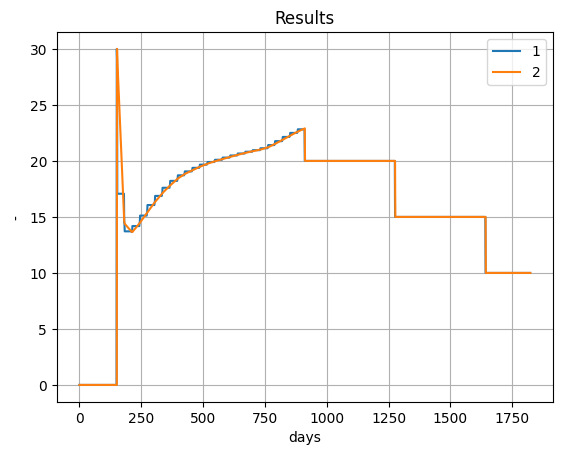

In [108]:
plot_time_series(Qwi_nn, Qw_inj[:,1])

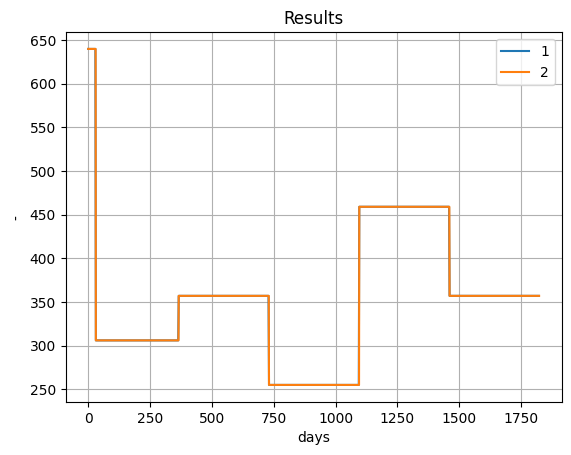

In [109]:
plot_time_series(Pwf_prod_nn, Pwf_prod[:,1])

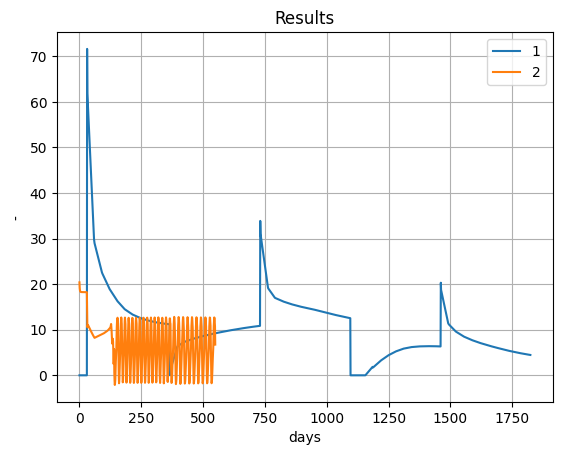

In [110]:
plot_time_series(Qo_prod[:,1], Qo_nn[:550])

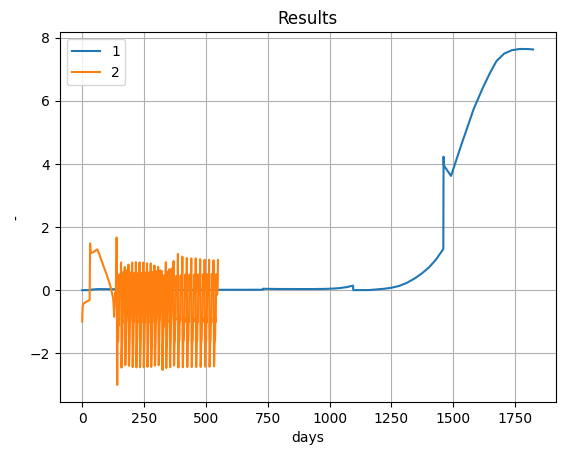

In [111]:
plot_time_series(Qw_prod[:,1], Qw_nn[:550])

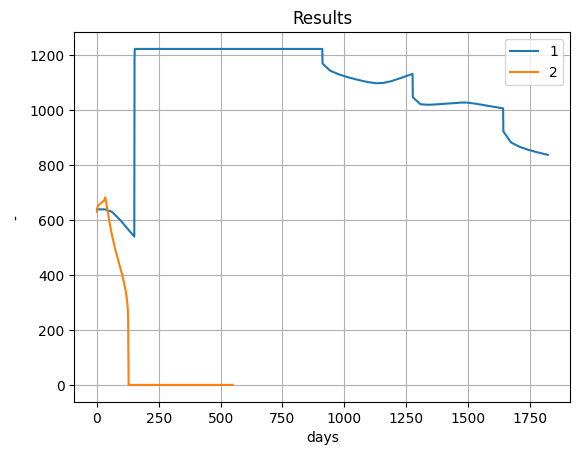

In [112]:
plot_time_series(Pwf_inj[:,1], Pwf_inj_nn[:550])

In [113]:
# plot_time_series(Pwf_inj[:,1])
# plot_time_series(Wp_inj[:,1])
# plot_time_series(Pwf_prod[:,1])
# plot_time_series(Np_prod[:,1], Wp_prod[:,1])